In [1]:
import catboost
import gc
import joblib
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [2]:
from utils.common import (
    sigmoid, 
    pad_column_name
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric,
    LGBM
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols, plot_heatmap
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, FIRST_FEATURES,
    RANGE_FEATURES, VELOCITY_FEATURES, SPEED_FEATURES
)

In [3]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"
EXP_PATH = "../experiments"

In [4]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [5]:
%load_ext autoreload
%autoreload

In [26]:
class LGBM:
    def __init__(self, exp_full_path, val_indices=None):
        self.path = exp_full_path
        self.target = []
        self.val_indices = val_indices
        self.models = {}
        self.feature_names = {}
        self.feature_importances = {}
        self.val_metrics = [0, 0, 0]
        self.master_feature_set = set()
        self.feature_imp_df = pd.DataFrame()
        self.feature_imp_summary = pd.DataFrame()
        self.read_models()
        self.get_master_feature_set()
        self.get_feature_importance_summary()
    
    def read_models(self):
        model_paths = [file for file in sorted(os.listdir(f"{self.path}/models")) if file.startswith("model")]
        for i, model_path in enumerate(model_paths):
            
            self.models[i] = joblib.load(f"{self.path}/models/{model_path}")
            
            if type(self.models[i]) == catboost.core.CatBoostClassifier:
                feature_name = self.models[i].feature_names_
                feature_imp = self.models[i].feature_importances_
            else:
                try:
                    feature_name = self.models[i].feature_name()
                    feature_imp = self.models[i].feature_importance()
                except:
                    feature_name = self.models[i].feature_name_
                    feature_imp = self.models[i].feature_importances_
            self.feature_names[i] = feature_name
            self.feature_importances[i] = feature_imp
    
    def get_master_feature_set(self):
        for feature_names in self.feature_names.values():
            self.master_feature_set = self.master_feature_set.union(feature_names)
    
    def process_data(self, data, labels):
        if "target" in data.columns:
            self.target = data["target"].values
        else:
            self.target = labels
        if "dummy" not in data.columns:
            data["dummy"] = np.nan
        return data
    
    def get_prediction_scores(self, data):
        kf = StratifiedKFold(n_splits=5)
        if self.val_indices is None:
            self.val_indices = [idx_va for idx_tr, idx_va in kf.split(data, self.target)]
        data["prediction"] = 0
        for model, idx_va in tqdm(zip(self.models.values(), self.val_indices)):
            data.loc[idx_va, "prediction"] = model.predict(
                data.loc[idx_va, model.feature_name_], 
                raw_score=True
            )
        return data
    
    def get_validation_performance(self, data):
        data = data.sort_values(by="prediction", ascending=False)
        data['weight'] = data['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * data['weight'].sum())
        data['weight_cumsum'] = data['weight'].cumsum()
        data["is_cutoff"] = 0
        data.loc[data['weight_cumsum'] <= four_pct_cutoff, "is_cutoff"] = 1
        data = data.reset_index()
        all_pos = np.sum(self.target)
        top4_pos = data.loc[(data["target"] == 1) & (data["is_cutoff"] == 1)].shape[0]
        d = top4_pos / all_pos
        
        data['random'] = (data['weight'] / data['weight'].sum()).cumsum()
        total_pos = (data['target'] * data['weight']).sum()
        data['cum_pos_found'] = (data['target'] * data['weight']).cumsum()
        data['lorentz'] = data['cum_pos_found'] / total_pos
        data['gini'] = (data['lorentz'] - data['random']) * data['weight']
        gini = data["gini"].sum()
        n_pos = np.sum(self.target)
        n_neg = self.target.shape[0] - n_pos
        gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)
        g = gini / gini_max
        
        self.val_metrics = [0.5 * (g + d), g, d]
        return data
    
    def get_test_prediction(self, test_data, batch_size=5000):
        scores_list = []
        for j, model in enumerate(self.models.values()):
            score_list = []
            print(f"Model {j + 1}")
            for i in tqdm(range(int(test_data.shape[0] / batch_size) + 1)):
                if type(model) == catboost.core.CatBoostClassifier:
                    score_list.append(model.predict(
                        test_data.loc[int(i*batch_size): int((i+1)*batch_size) - 1, self.feature_names[j]], 
                        prediction_type='RawFormulaVal'
                    ))
                else:
                    score_list.append(model.predict(
                        test_data.loc[int(i*batch_size): int((i+1)*batch_size) - 1, self.feature_names[j]], 
                        raw_score=True
                    ))
            scores_list.append(np.concatenate(score_list))
        test_data["prediction"] = np.mean(scores_list, axis=0)
        return test_data
    
    @staticmethod
    def get_agg_type(df):
        if "feature" in df.columns:
            return df["feature"].str.split("_").str[2:].str.join("_").values
        else:
            return df.index.str.split("_").str[2:].str.join("_").values
    
    @staticmethod
    def get_base_feature_column(df):
        if "feature" in df.columns:
            return df["feature"].str.split("_").str[:2].str.join("_").values
        else:
            return df.index.str.split("_").str[:2].str.join("_").values
    
    def get_feature_importance_summary(self):
        feature_imps = []
        for i, model in self.models.items():
            feature_imps.append(
                pd.DataFrame(
                    {
                        "feature": self.feature_names[i], 
                        f"importance{i}": self.feature_importances[i]
                    }
                ).set_index("feature")
            )
        feature_imp_df = pd.concat(feature_imps, axis=1)
        feature_imp_df["average_importance"] = feature_imp_df.mean(axis=1)
        feature_imp_df = feature_imp_df.reset_index()
        feature_imp_df = feature_imp_df.sort_values("average_importance", ascending=False)
        
        feature_imp_df["agg_type"] = self.get_agg_type(feature_imp_df)
        feature_imp_df["base_feature"] = self.get_base_feature_column(feature_imp_df)
        self.feature_imp_df = feature_imp_df.copy()
        del feature_imp_df
        
        pivoted_feature_imp_df = pd.pivot_table(
            self.feature_imp_df, 
            values="average_importance", 
            index="base_feature", 
            columns="agg_type"
        ).drop(columns="", errors="ignore").reset_index()
        
        self.feature_imp_summary = pivoted_feature_imp_df.loc[
            (pivoted_feature_imp_df["base_feature"].str.contains("_")) & 
            (pivoted_feature_imp_df["base_feature"].str.len() < 10)
        ]
    
    def inference_full(self, data, batch_size=5000):
        scores_list = []
        for j, model in enumerate(self.models.values()):
            score_list = []
            print(f"Model {j + 1}")
            for i in tqdm(range(int(data.shape[0] / batch_size) + 1)):
                score_list.append(model.predict(
                    data.loc[int(i*batch_size): int((i+1)*batch_size) - 1, model.feature_name()], 
                    raw_score=True
                ))
            scores_list.append(np.concatenate(score_list))
        score_df = pd.DataFrame(np.stack(scores_list).T, columns=[f"score{i}" for i in range(1, 6)])
        data["prediction"] = score_df.mean(axis=1)
        return data
    
    def inference_fold(self, data, target, batch_size=5000, shuffle_random_state=False):
        scores_list = []
        if shuffle_random_state:
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=shuffle_random_state)
        else:
            kf = StratifiedKFold(n_splits=5)
        for model, (idx_tr, idx_va) in zip(self.models.values(), kf.split(data, target)):
            data.loc[idx_va, "prediction"] = model.predict(
                data.loc[idx_va, model.feature_name()],
                raw_score=True
            )
        return data
    
    def run_validation_check(self, data, labels):
        data = self.process_data(data)
        data = self.get_prediction_scores(data, labels)
        data = self.get_validation_performance(data)
        return data

### Read Model

In [27]:
%%time
cboost = LGBM(
    exp_full_path="../experiments/catboost_new_exp"
)
cboost_master_feature_set = cboost.master_feature_set

CPU times: user 268 ms, sys: 20.8 ms, total: 288 ms
Wall time: 301 ms


In [28]:
fi = cboost.feature_imp_summary

In [29]:
fi.loc[(fi["last"] - fi["third_last"]) < -15, ["base_feature", "last", "second_last", "third_last"]]

agg_type,base_feature,last,second_last,third_last


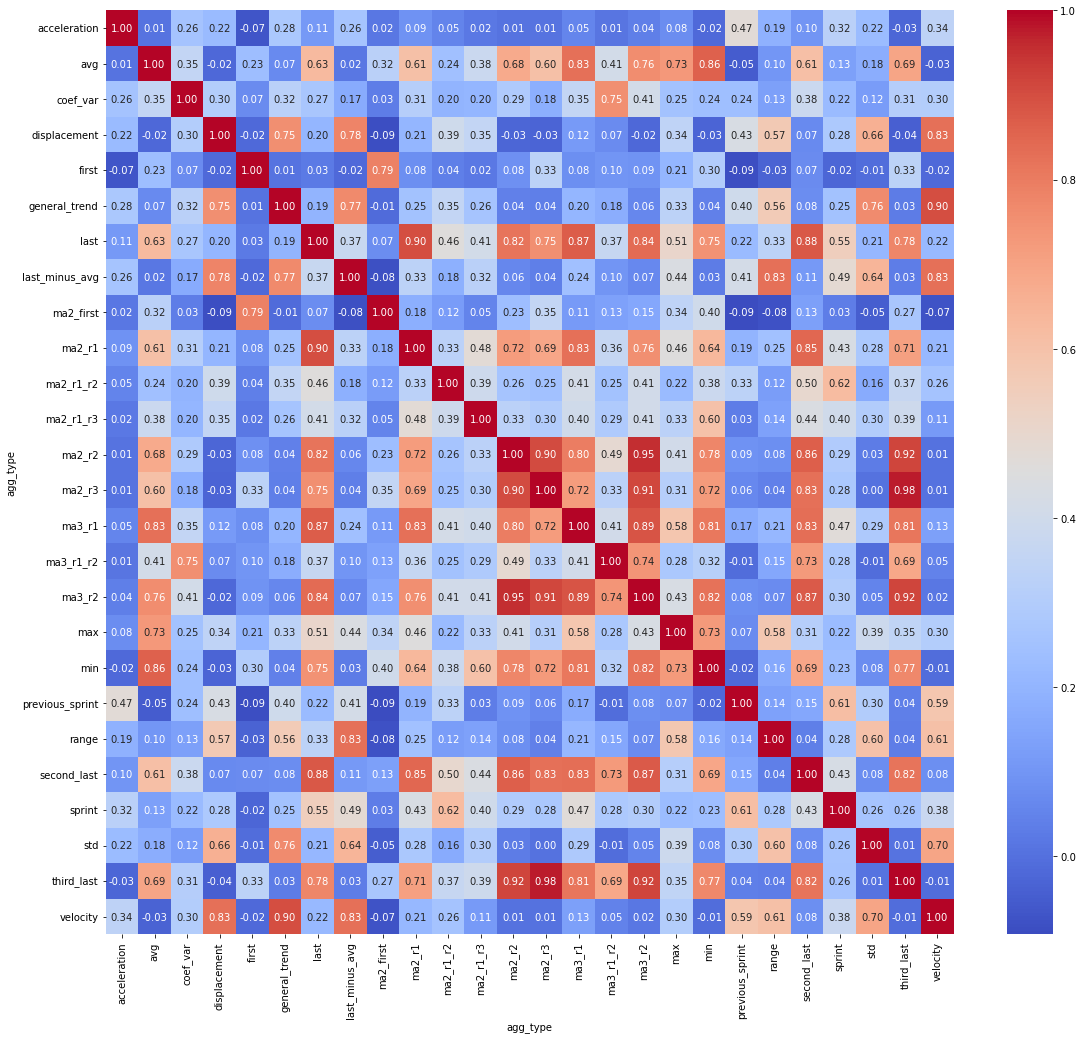

In [30]:
plot_heatmap(fi.corr(), annot=True, figsize=(19, 17), fmt=".2f")

In [12]:
# %%time
# lgbm_gbdt_shuffled = LGBM(
#     exp_full_path="../experiments/lgbm_gbdt_shuffled_exp"
# )
# gbdt_shuffled_master_feature_set = lgbm_gbdt_shuffled.master_feature_set

In [13]:
# master_feature_set = sorted(gbdt_master_feature_set.union(
#     gbdt_shuffled_master_feature_set
# ))
# len(set(master_feature_set))

### Read Train Data (Error Analysis)

In [10]:
labels = read_file(f"{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


In [11]:
target = labels["target"]

In [25]:
%%time
raw_train = read_file(f"{RAW_TRAIN_PICKLE_PATH}/raw_train_data.pkl")

Shape of data: (5531451, 193)
CPU times: user 1.69 s, sys: 2.22 s, total: 3.91 s
Wall time: 5.46 s


In [26]:
%%time
train_agg = read_file(f"{PROCESSED_DATA_PATH}/train_agg_complete2.pkl")

Shape of data: (458913, 4334)
CPU times: user 3.29 s, sys: 9.37 s, total: 12.7 s
Wall time: 17.6 s


In [27]:
%%time
train_agg = train_agg.loc[:, list(gbdt_master_feature_set)]

CPU times: user 1.3 s, sys: 8.21 s, total: 9.51 s
Wall time: 15.6 s


In [28]:
%%time
train_agg = lgbm_gbdt.inference_fold(train_agg, target)

CPU times: user 2min 37s, sys: 19.7 s, total: 2min 57s
Wall time: 47.6 s


In [29]:
train_agg.head()

,D_52_avg,R_21_last_minus_avg,D_54_velocity,D_43_previous_sprint,D_45_ma3_r1,R_12_max,D_83_last,D_39_ma3_r4,R_6_general_trend,B_27_general_trend,...,D_75_avg,D_144_ma3_r1_r2,D_133_ma3_r1_r3,B_25_min,D_103_third_last,B_31_ma3_r4,D_45_previous_sprint,R_3_first,D_87_avg,prediction
0,0.204972,0.0,0.0,NaN,0.736762,1.0,0.0,1.000000,-0.008713,0.006823,...,0.461538,0.657470,0.702797,0.000646,1.0,1.0,0.009941,0,NaN,-7.248763
1,0.158313,0.0,0.0,-0.003197,0.265345,1.0,0.0,10.666667,0.016054,0.001786,...,0.000000,0.884470,1.748812,0.002951,0.0,1.0,-0.002287,0,NaN,-6.892573
2,0.199863,0.0,0.0,NaN,0.246921,1.0,0.0,0.000000,0.012007,-0.006180,...,0.230769,2.746483,0.946326,0.001164,0.0,1.0,0.001868,0,NaN,-6.831316
3,0.199698,0.0,0.0,0.001636,0.078275,1.0,0.0,5.333333,0.006641,0.017664,...,0.230769,0.929107,0.682116,0.006479,0.0,1.0,0.000147,0,NaN,-5.152160
4,0.233470,0.0,0.0,-0.006678,0.068835,1.0,0.0,0.000000,0.006119,0.002160,...,1.846154,1.020872,1.307668,0.002141,1.0,1.0,0.006563,1,NaN,-5.520156


In [30]:
%%time
eval_df = get_final_metric_df(train_agg.iloc[:, :-1], target, train_agg["prediction"])

CPU times: user 2.96 s, sys: 11.6 s, total: 14.6 s
Wall time: 43 s


In [31]:
eval_df.loc[eval_df["is_cutoff"] == 1, "target"].sum() / eval_df["target"].sum()

0.665078937624129

In [32]:
%%time
false_negative_indices = eval_df.loc[(eval_df["target"] == 1) & (eval_df["is_cutoff"] == 0)].index.tolist()
false_positive_indices = eval_df.loc[(eval_df["target"] == 0) & (eval_df["is_cutoff"] == 1)].index.tolist()

CPU times: user 921 ms, sys: 6.52 s, total: 7.44 s
Wall time: 12.7 s


In [33]:
len(false_negative_indices), len(false_positive_indices)

(39798, 9889)

In [34]:
wrong_indices = eval_df.loc[false_negative_indices + false_positive_indices, :].index.tolist()

In [35]:
len(wrong_indices)

49687

In [36]:
%%time
summary_count_df = raw_train.groupby("customer_ID").count()
summary_count_df = summary_count_df.reset_index()

In [40]:
for col in tqdm(summary_count_df.columns[4:]):
    summary_count_df[col] = 1 - (summary_count_df[col] / summary_count_df["row_number"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 19.11it/s]


In [41]:
wrong_pred_missing_count_df = summary_count_df.loc[wrong_indices]
wrong_pred_missing_count_df = wrong_pred_missing_count_df.sort_index()
correct_pred_missing_count_df = summary_count_df.loc[~summary_count_df.index.isin(wrong_indices)]

In [42]:
correct_mean_df = correct_pred_missing_count_df.iloc[:, 3:].mean()

In [46]:
wrong_mean_df = wrong_pred_missing_count_df.iloc[:, 3:].mean()

In [67]:
((wrong_mean_df / correct_mean_df - 1).sort_values(ascending=False) > 0).sum()

79

In [69]:
((wrong_mean_df / correct_mean_df - 1).sort_values(ascending=False) < 0).sum()

42

In [88]:
(wrong_mean_df / (correct_mean_df + wrong_mean_df)).sort_values(ascending=False).to_csv(
    f"{EXP_PATH}/percent_of_missing_from_wrong.csv"
)

In [64]:
wrong_mean_df["D_124"], correct_mean_df["D_124"]

(0.11441915635970326, 0.05736670876813808)

0.0

In [ ]:
train_, test_ = train_test_split(score_df, test_size=0.2, random_state=1020)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression()
logreg.fit(train_.drop(columns="target"), train_["target"])

In [ ]:
y_pred = logreg.predict_proba(test_.drop(columns="target"))[:, 1]

In [ ]:
y_true = test_["target"].values

In [ ]:
amex_metric(y_true, y_pred)

In [ ]:
# del train_agg

In [ ]:
# lgbm_gbdt.run_validation_check(data=train_agg, labels=labels["target"].values)

In [ ]:
lgbm_gbdt.val_metrics

In [ ]:
# train_agg = lgbm_dart.run_validation_check(data=train_agg)

In [ ]:
# lgbm_dart.val_metrics

### Error Analysis

In [ ]:
train_agg.loc[train_agg["target"] == 0, "prediction"].describe()

In [ ]:
train_agg.loc[train_agg["target"] == 1, "prediction"].describe()

### High Pred Score Analysis

In [ ]:
success_pos_df = train_agg.loc[
    (train_agg["target"] == 1) & (train_agg["is_cutoff"] == 1)
]

In [ ]:
fail_neg_df = train_agg.loc[
    (train_agg["target"] == 0) & (train_agg["is_cutoff"] == 1)
]

### Low Pred Score Analysis

In [ ]:
success_neg_df = train_agg.loc[
    (train_agg["target"] == 0) & (train_agg["is_cutoff"] == 0)
]

In [ ]:
fail_pos_df = train_agg.loc[
    (train_agg["target"] == 1) & (train_agg["is_cutoff"] == 0)
]

In [ ]:
success_neg_df["num_statements"].describe()

In [ ]:
fail_pos_df["num_statements"].describe()

In [ ]:
base_feature = "P_2"

In [ ]:
# for col in get_cols(success_neg_df, base_feature):
#     my_dict = {
#         'True Negative': success_neg_df[col].dropna().values, 
#         'False Negative': fail_pos_df[col].dropna().values,
#         'True Positive': success_pos_df[col].dropna().values, 
#     }
#     fig, ax = plt.subplots(figsize=(15, 12))
#     ax.boxplot(my_dict.values())
#     ax.set_xticklabels(my_dict.keys())
#     plt.title(f"{col}")
#     plt.show()

In [ ]:
# success_pos_df.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp3/success_positive.pkl")
# fail_pos_df.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp3/failed_positive.pkl")
# success_neg_df.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp3/success_negative.pkl")
# fail_neg_df.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp3/failed_negative.pkl")

### Read Test Data

In [11]:
%%time
if 'train_agg' in locals():
    del train_agg
# test_agg = read_file(f"{PROCESSED_DATA_PATH}/test_agg_complete2.pkl")
test_agg = read_file(f"{PROCESSED_DATA_PATH}/test_agg_exp.pkl")
gc.collect()

Shape of data: (924621, 4647)
CPU times: user 7.09 s, sys: 21.6 s, total: 28.7 s
Wall time: 54.5 s


42503

In [21]:
%%time
test_agg = test_agg.loc[:, list(cboost_master_feature_set)]
test_agg.shape

CPU times: user 730 ms, sys: 5.76 s, total: 6.49 s
Wall time: 18.2 s


(924621, 2925)

In [31]:
test_agg.shape

(924621, 2925)

In [32]:
cat_features = test_agg.select_dtypes("category").columns

In [33]:
test_agg.loc[:, cat_features] = test_agg.loc[:, cat_features].astype(float).fillna(-1).astype(int).astype("category")

In [34]:
test_agg = cboost.get_test_prediction(test_agg)

Model 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:28<00:00,  6.44it/s]


Model 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:24<00:00,  7.66it/s]


Model 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:24<00:00,  7.63it/s]


Model 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:24<00:00,  7.67it/s]


Model 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:24<00:00,  7.59it/s]


In [35]:
with open(f"{cboost.path}/best_scores.json", "r+") as outfile:
    best_scores_json = json.load(outfile)
np.mean(list(best_scores_json["validation"].values()))

0.7961415234827787

In [59]:
# from sklearn.preprocessing import MinMaxScaler

# score_df = pd.DataFrame(np.array(scores_list).T, columns=range(1, 6))
# minmax_scaler = MinMaxScaler()
# score_df = pd.DataFrame(minmax_scaler.fit_transform(score_df), columns=range(1, 6))
# score_df.describe()
# test_agg["prediction"] = np.mean(score_df, axis=1) 

In [ ]:
test_agg["prediction"]

In [36]:
submission = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission25_0.799.csv")
submission["prediction"] = test_agg["prediction"].values
# submission["prediction"] = test_score_df.applymap(sigmoid).mean(axis=1)
submission.to_csv(f"{SUBMISSION_DATA_PATH}/submission61_0.79614.csv", index=False)

In [ ]:
# test_agg = lgbm_dart.get_test_prediction(test_agg)

0         0.024131
1         0.001219
2         0.044938
3         0.264474
4         0.893939
            ...   
924616    0.014769
924617    0.919875
924618    0.600544
924619    0.482939
924620    0.057088
Length: 924621, dtype: float64

In [ ]:
# submission["prediction"].apply(sigmoid)

In [ ]:
test_score_df

#### Take the average of all CV models' predictions

In [ ]:
# np.mean(scores_list, axis=0)

In [ ]:
test_agg["prediction"] = np.mean(scores_list, axis=0)

In [ ]:
def get_metric_columns(df):
    df = df.sort_values(by="prediction", ascending=False)
    df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
    four_pct_cutoff = int(0.04 * df['weight'].sum())
    df['weight_cumsum'] = df['weight'].cumsum()
    df["is_cutoff"] = 0
    df.loc[df['weight_cumsum'] <= four_pct_cutoff, "is_cutoff"] = 1
    df = df.reset_index()
    
    df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
    total_pos = (df['target'] * df['weight']).sum()
    df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
    df['lorentz'] = df['cum_pos_found'] / total_pos
    df['gini'] = (df['lorentz'] - df['random']) * df['weight']
    return df

In [ ]:
test_agg["prediction"].describe()

In [ ]:
del scores_list

In [ ]:
test_agg.loc[(test_agg["P_2_last"] < 0.4) & (test_agg["prediction"] < 0), "prediction"] += 4

#### Take a look on CV score

In [ ]:
with open(f"{EXP_FULL_PATH}/best_scores.json", "r+") as outfile:
    best_scores = json.load(outfile)
np.mean(list(best_scores["validation"].values()))

### Manual Adjustment

In [ ]:
test_agg["P_2_last"].describe()

#### Prepare the submission csv, then export out new submission file

In [ ]:
submission = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission25_0.799.csv")
submission["prediction"] = test_agg["prediction"].values
submission.to_csv(f"{SUBMISSION_DATA_PATH}/submission__.csv", index=False)

### Analyze Feature Importance

#### Read old feature importance summary df

In [ ]:
old_feature_imp_df = pd.read_csv(f"{EXP_FULL_PATH}/feature_imp_summary.csv")

#### Construct new feature importance summary df

In [ ]:
feature_imp_df.loc[feature_imp_df["agg_type"] == ""]

In [ ]:
corr_df = pd.read_csv(f"{PROCESSED_DATA_PATH}/raw_column_correlation/train_corr_df.csv")
base_features = corr_df.columns.tolist()

In [ ]:
old_feature_imp_df

In [ ]:
new_feature_imp_df.to_csv(f"{PROCESSED_DATA_PATH}/feature_imp_summary.csv", index=False)

In [ ]:
# validation_indices = joblib.load(f'{EXP_FULL_PATH}/5_fold_val_indices.pkl')

## Feature Importance

In [ ]:
# fi_master = read_file(f"{EXP_PATH}/feature_imp_general_summary.csv")

In [23]:
fi_gbdt = lgbm_gbdt.feature_imp_summary

In [26]:
# fi_gbdt.to_csv(f"{EXP_PATH}/feature_imp_summary4.csv", index=False)

In [ ]:
fi_dart = lgbm_dart.feature_imp_df

In [8]:
lgbm_gbdt.feature_imp_summary.to_csv(f"{EXP_PATH}/feature_imp_summary3.csv", index=False)

In [ ]:
lgbm_gbdt_shuffled.feature_imp_df.groupby("agg_type")["average_importance"].sum().sort_values().iloc[-30:]

In [ ]:
set(fi_gbdt["base_feature"]) - set(fi_dart["base_feature"])

In [ ]:
set(fi_dart["base_feature"]) - set(fi_gbdt["base_feature"])

In [ ]:
# lgbm_dart.feature_imp_df

In [ ]:
imp_df = lgbm_gbdt.feature_imp_df.copy()
imp_summary = lgbm_gbdt.feature_imp_summary.copy()

In [ ]:
half_max_imp_df = imp_df.loc[imp_df["average_importance"] > 0.5*imp_df["average_importance"].max()]

In [ ]:
top_base_features = imp_summary.loc[imp_summary["base_feature"].isin(half_max_imp_df["base_feature"].tolist())]

In [ ]:
plot_heatmap(top_base_features.set_index("base_feature"), annot=True, figsize=(18, 18), fmt=".1f")

In [ ]:
lgbm_gbdt.feature_imp_summary.to_csv(f"{EXP_PATH}/feature_imp_summary3.csv", index=False)

In [ ]:
noob_features_df = feature_imp_df["average_importance"].nsmallest(int(feature_imp_df.shape[0] * 0.04))
noob_features = noob_features_df.index.tolist()

In [ ]:
top_features_df = feature_imp_df["average_importance"].nlargest(int(feature_imp_df.shape[0] * 0.9))
top_features = top_features_df.index.tolist()

In [ ]:
pd.Series([f.split("_")[-1] for f in top_features]).value_counts()

In [ ]:
pd.Series(top_features, name="feature").to_csv("top_features.csv", index=False)

In [ ]:
# used_features = set(feature_imp_df.index.tolist())

In [ ]:
mean_features = pad_column_name(MEAN_FEATURES, suffix="_avg")
min_features = pad_column_name(MIN_FEATURES, suffix="_min")
max_features = pad_column_name(MAX_FEATURES, suffix="_max")
last_features = pad_column_name(LAST_FEATURES, suffix="_last")
first_features = pad_column_name(FIRST_FEATURES, suffix="_first")

In [ ]:
range_features = pad_column_name(RANGE_FEATURES, suffix="_range")
velocity_features = pad_column_name(VELOCITY_FEATURES, suffix="_velocity")
speed_features = pad_column_name(SPEED_FEATURES, suffix="_speed")

In [ ]:
all_features = (
    mean_features + min_features + max_features + last_features + first_features
    + range_features + velocity_features + speed_features
)

In [ ]:
len(all_features)

In [ ]:
set(top_features) - set(all_features)

In [ ]:
top_features

In [ ]:
feature_imp_df = feature_imp_df.loc[feature_imp_df["average_importance"] > 0]
feature_imp_subset = feature_imp_df.loc[feature_imp_df["average_importance"] > 200].reset_index()

In [ ]:
# feature_imp_subset.loc[feature_imp_subset["feature"].str.contains("last")].sort_values("feature")

In [ ]:
t = feature_imp_subset.copy()

In [ ]:
t.loc[t["feature"] == "D_128_first"]

In [ ]:
# feature_imp_df.index.tolist()

In [ ]:
feature_list = feature_imp_df.index.tolist()
len(feature_list)

In [ ]:
original_score

In [ ]:
simulated_score_list = []
for feature in feature_list[::-1]:
    temp_train_val = train_val.copy()
    temp_train_val[feature] = np.nan
    for i, indices in enumerate(validation_indices):
        temp_model = models[i]
        temp_val = temp_train_val.loc[indices, temp_model.feature_name_]
        temp_train_val.loc[indices, "score"] = temp_model.predict_proba(temp_val, raw_score=True)
    simulated_score = amex_metric(temp_train_val["target"], temp_train_val["score"])
    simulated_score_list.append(simulated_score)
    if simulated_score >= original_score:
        sign = "+"
    else:
        sign = ""
    if abs(simulated_score - original_score) >= 1e-4:
        print(feature, f" {sign}{(simulated_score - original_score):.4f}")
    print(f"{feature} done")
    del temp_train_val
    gc.collect()

In [ ]:
test = read_file(f"{RAW_TEST_PICKLE_PATH}/test_data.pkl")

In [ ]:
test.loc[test["row_number"] > 12]

In [ ]:
test_agg = process_test_data(test)

In [ ]:
test_agg.head()

In [ ]:
del test

In [ ]:
for i, model in enumerate(models.values()):
    model_input = test_agg.loc[:, model.feature_name_]
    test_agg.loc[:, f"score{i}"] = model.predict_proba(model_input, raw_score=True)

In [ ]:
test_agg.head()

In [ ]:
new_result_sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission19_0.796.csv")

In [ ]:
old_result_sub = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission17_0.796.csv")

In [ ]:
plt.scatter(old_result_sub["prediction"], new_result_sub["prediction"])

In [ ]:
np.corrcoef(old_result_sub["prediction"], new_result_sub["prediction"])

In [ ]:
merged_result = new_result_sub.merge(old_result_sub, on="customer_ID", how="left")

In [ ]:
merged_result["x_positive"] = (merged_result["prediction_x"] >= 0)

In [ ]:
merged_result["y_positive"] = (merged_result["prediction_y"] >= 0)

In [ ]:
neg_neg_indices = merged_result.loc[(~merged_result["x_positive"]) & (~merged_result["y_positive"])].index

In [ ]:
merged_result.loc[neg_neg_indices, "prediction"] = merged_result.loc[neg_neg_indices, :].min(axis=1)

In [ ]:
pos_pos_indices = merged_result.loc[(merged_result["x_positive"]) & (merged_result["y_positive"])].index

In [ ]:
merged_result.loc[pos_pos_indices, "prediction"] = merged_result.loc[pos_pos_indices, :].max(axis=1)

In [ ]:
merged_result["prediction"].isnull().sum()

In [ ]:
merged_result.loc[merged_result["prediction"].isnull(), "prediction"] = \
(merged_result.loc[merged_result["prediction"].isnull(), "prediction_x"] + \
merged_result.loc[merged_result["prediction"].isnull(), "prediction_y"]) / 2

In [ ]:
merged_result = merged_result.drop(columns=["prediction_x", "prediction_y", "x_positive", "y_positive"])

In [ ]:
merged_result.to_csv(f"{SUBMISSION_DATA_PATH}/submission23.csv", index=False)

In [ ]:
new_result_sub["prediction"] = np.max([new_result_sub["prediction"].values, old_result_sub["prediction"].values], axis=0)

In [ ]:
new_result_sub["prediction"] += old_result_sub["prediction"]

In [ ]:
new_result_sub["prediction"] /= 2

In [ ]:
new_result_sub.to_csv(f"{SUBMISSION_DATA_PATH}/submission22.csv", index=False)

In [ ]:
result_sub = test_agg.loc[:, [c for c in test_agg.columns if c.startswith("score")]].mean(axis=1).reset_index()

In [ ]:
result_sub.columns = ["customer_ID", "prediction"]

In [ ]:
result_sub.to_csv("submission20.csv", index=False)

In [ ]:
single_record_index = test_agg.loc[test_agg["num_records"] == 1].index.tolist()

In [ ]:
final_df13 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission13_0.796.csv")
final_df13["prediction_13"] = sigmoid(final_df13["prediction"])
final_df13 = final_df13.drop(columns="prediction")

In [ ]:
final_df16 = pd.read_csv(f"{SUBMISSION_DATA_PATH}/submission16_0.782.csv")
final_df16["prediction_16"] = sigmoid(final_df16["prediction"])
final_df16 = final_df16.drop(columns="prediction")

In [ ]:
mega_df = final_df13.merge(final_df16, on="customer_ID", how="left")

In [ ]:
mega_df.loc[:, "prediction"] = (
    mega_df.loc[:, "prediction_16"] * 0.1 \
    + mega_df.loc[:, "prediction_13"] * 0.9
)

In [ ]:
mega_df.loc[single_record_index, "prediction"] = (
    mega_df.loc[single_record_index, "prediction_16"] * 0.8 \
    + mega_df.loc[single_record_index, "prediction_13"] * 0.2
)

In [ ]:
mega_df = mega_df.drop(columns=["prediction_13", "prediction_16"])

In [ ]:
mega_df["prediction"] = 0.55 * mega_df["prediction_x"] + 0.45 * mega_df["prediction_y"]
mega_df = mega_df.drop(columns=["prediction_x", "prediction_y"])

In [ ]:
mega_df.to_csv(f"{SUBMISSION_DATA_PATH}/submission18.csv", index=False)